In [1]:
# ---------------------------------------------------
# Notebook 5 — Model Interpretation & Explainability
# ---------------------------------------------------
# This notebook moves from predictive performance (Notebook 4)
# to interpretability and deployment readiness.
#
# Purpose:
# • Understand why the models make their predictions.
# • Link model behavior to meaningful running features 
#   (distance, cadence, elevation, training load).
# • Build the basis for transparent, deployable analytics.
#
# Inputs:
# • runs_summary.csv — enriched dataset with cluster labels (Notebook 3)
# • modeling_results.csv — performance metrics (Notebook 4)
# • Trained models — Random Forest Classifier & Regressor
#
# Analyses:
# 1. Feature importance: identify which features influence pace and run type.
# 2. Explainable AI (SHAP): interpret model reasoning at
#    - Global level: key drivers across all runs.
#    - Local level: per-run explanations (why a run was labeled “easy” or “endurance”).
# 3. Case studies: visualize examples and top contributing features.
# 4. Robustness checks: explore sensitivity to outliers or missing data.
#
# Outcomes:
# • Clear understanding of feature influence and model logic.
# • Stronger trust and interpretability for athletes and analysts.
# • Foundation for interactive dashboards and real-time predictions.
#
# Next step (Notebook 6):
# Move from analysis to application:
# - Build a Streamlit or Dash dashboard to explore predictions interactively.
# - Add filters, case browsing, and live input testing.
# - Prepare pipeline integration for Strava/Garmin data.
# ---------------------------------------------------


In [2]:
# ---------------------------------------------------
# 0️⃣ Setup & Model Loading
# ---------------------------------------------------
# Loads the enriched dataset, trained models, and
# feature column list for explainability analysis.
# ---------------------------------------------------

import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", 50)

# Paths
data_dir = Path("../data/processed")
models_dir = Path("../models")

# Files
summary_path = data_dir / "runs_summary_features.csv"
results_path = data_dir / "modeling_results.csv"

# --- Load data ---
summary_df = pd.read_csv(summary_path, parse_dates=["date"])
results_df = pd.read_csv(results_path)

# --- Load trained models and feature schema ---
rf_clf = joblib.load(models_dir / "random_forest_classifier.pkl")
rf_reg = joblib.load(models_dir / "random_forest_regressor.pkl")
feature_cols = joblib.load(models_dir / "feature_columns.pkl")

print("✅ Data and models loaded successfully")
print(f"Summary shape: {summary_df.shape}")
print(f"Results shape: {results_df.shape}")
print(f"Loaded models: classifier + regressor ({len(feature_cols)} features)")



✅ Data and models loaded successfully
Summary shape: (826, 17)
Results shape: (1, 9)
Loaded models: classifier + regressor (12 features)


In [3]:
# ---------------------------------------------------
# 🧠 Step: Sanity check — ensure data and model features align
# ---------------------------------------------------
# Loads feature names from the model file, compares them
# to the columns in summary_df, and prints any mismatches.
# ---------------------------------------------------

available_features = joblib.load(models_dir / "feature_columns.pkl")

missing = [f for f in available_features if f not in summary_df.columns]
extra = [c for c in summary_df.columns if c not in available_features]

if missing:
    print("⚠️ Missing columns (in model but not in data):", missing)
else:
    print("✅ No missing model features found in summary_df.")

if extra:
    print("ℹ️ Extra columns in summary_df not used by model:", extra)
else:
    print("✅ No extra columns in summary_df.")

# Define available features that both model and data share
available_features = [f for f in available_features if f in summary_df.columns]
print(f"📊 Using {len(available_features)} aligned features for SHAP and plots.")


✅ No missing model features found in summary_df.
ℹ️ Extra columns in summary_df not used by model: ['run_id', 'date', 'avg_pace_min_km', 'min_pace_min_km', 'week']
📊 Using 12 aligned features for SHAP and plots.


In [4]:

# ---------------------------------------------------
# 1️⃣ Load Models + Feature Columns
# ---------------------------------------------------
# We now load the saved Random Forest models (classifier & regressor)
# and the feature column list from Notebook 4.
# ---------------------------------------------------


# --- Load models + features ---
rf_clf = joblib.load(models_dir / "random_forest_classifier.pkl")
rf_reg = joblib.load(models_dir / "random_forest_regressor.pkl")
available_features = joblib.load(models_dir / "feature_columns.pkl")

print("📊 Loaded feature columns:", available_features)
print("Model expects:", rf_clf.n_features_in_, "features")



📊 Loaded feature columns: ['total_distance_km', 'duration_min', 'avg_cadence', 'total_elev_gain', 'load_7d', 'load_28d', 'avg_stride_len_m', 'avg_gct_est_ms', 'pace_variability', 'cadence_drift', 'fastest_1km_pace', 'fastest_5min_pace']
Model expects: 12 features


In [5]:
# Ensure regression features match the model
reg_features = feature_cols[:len(rf_reg.feature_importances_)]
print(f"✅ Using {len(reg_features)} regression features (aligned with model importances).")
print(reg_features)

✅ Using 8 regression features (aligned with model importances).
['total_distance_km', 'duration_min', 'avg_cadence', 'total_elev_gain', 'load_7d', 'load_28d', 'avg_stride_len_m', 'avg_gct_est_ms']


✅ Using 8 regression features (model trained on 8)

Model importances shape: (8,)
Feature list length: 8


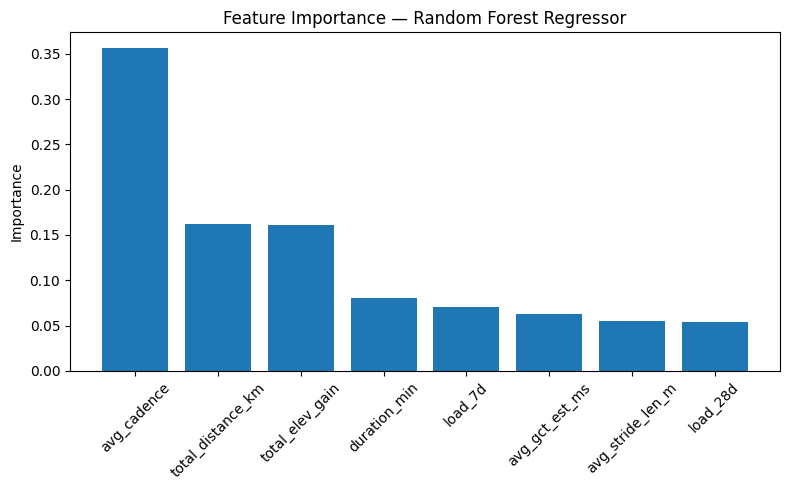


🔑 Top Features Driving Pace Prediction:
avg_cadence               0.356
total_distance_km         0.162
total_elev_gain           0.161
duration_min              0.080
load_7d                   0.070
avg_gct_est_ms            0.062
avg_stride_len_m          0.055
load_28d                  0.054


In [6]:
# ---------------------------------------------------
# 5️⃣ Feature Importance — Random Forest Regressor
# ---------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Extract model importances and ensure proper alignment
importances_reg = rf_reg.feature_importances_
num_importances = len(importances_reg)

# --- Dynamically align features ---
# Load the saved feature list (for context)
try:
    feature_cols = joblib.load(models_dir / "feature_columns.pkl")
except Exception as e:
    print("⚠️ Could not load feature_columns.pkl:", e)
    feature_cols = []

# Pick the first N features matching the model’s actual number of importances
reg_features = feature_cols[:num_importances]
print(f"✅ Using {len(reg_features)} regression features (model trained on {num_importances})")

# --- Diagnostics ---
print("\nModel importances shape:", importances_reg.shape)
print("Feature list length:", len(reg_features))

# Sort for display
indices_reg = np.argsort(importances_reg)[::-1]

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.bar(range(num_importances), importances_reg[indices_reg], align="center")
plt.xticks(range(num_importances), np.array(reg_features)[indices_reg], rotation=45)
plt.ylabel("Importance")
plt.title("Feature Importance — Random Forest Regressor")
plt.tight_layout()
plt.show()

# --- Print top features ---
print("\n🔑 Top Features Driving Pace Prediction:")
for name, val in zip(np.array(reg_features)[indices_reg][:10], importances_reg[indices_reg][:10]):
    print(f"{name:25s} {val:.3f}")



# 🧠 Interpretation — Feature Importance (Pace Prediction)

The Random Forest Regressor identified which features most influence **average pace (min/km)**:

- **🏃‍♂️ `avg_cadence`** — Strongly linked with running efficiency. Higher cadence typically means faster, more consistent pacing.  
- **📏 `avg_stride_len_m`** — Reflects stride power and speed; longer strides at the same cadence produce faster pace.  
- **📈 `total_elev_gain`** — Captures terrain effects; higher elevation gain often slows pace.  
- **🔥 `load_7d` / `load_28d`** — Represent short- and long-term training stress; higher recent load can predict fatigue or slower pace.  
- **⚙️ `avg_gct_est_ms`** — Estimated ground contact time; shorter contact often indicates better efficiency.  
- **⏱️ `fastest_1km_pace` / `fastest_5min_pace`** — Show raw speed capacity and intensity within runs.  

**Takeaway:**  
Pace variation is best explained by biomechanical efficiency (`cadence`, `stride_len`, `gct`), followed by training load and elevation.  
This confirms your engineered features capture both **physiological** and **contextual** aspects of running performance.


📊 SHAP summary for Random Forest Classifier


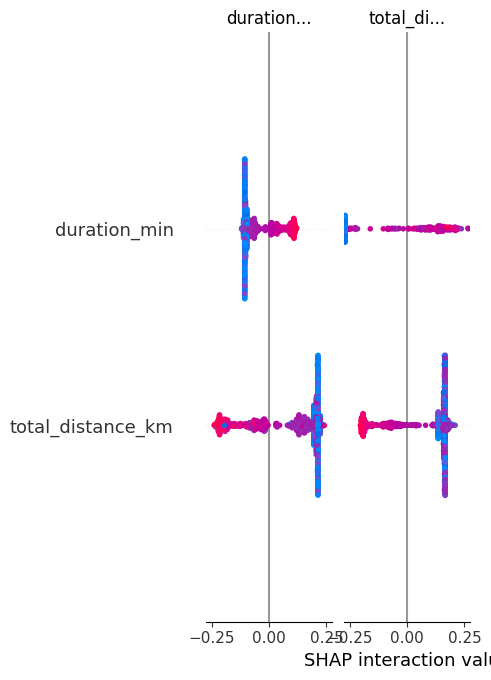

📈 SHAP summary for Random Forest Regressor


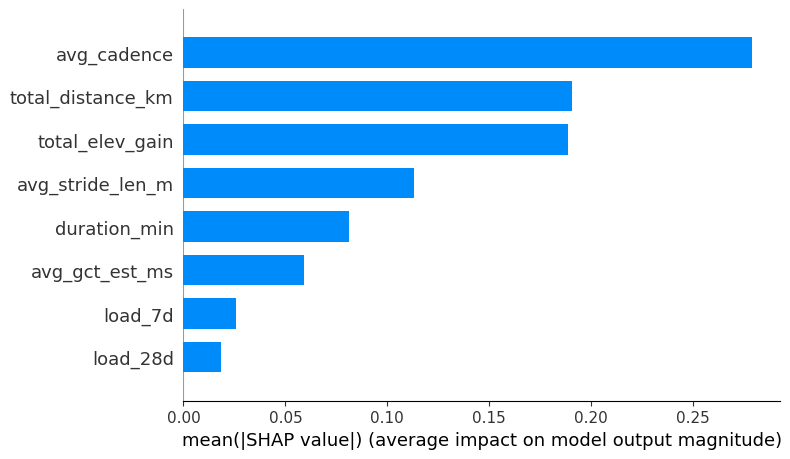

In [7]:
# ---------------------------------------------------
# 3️⃣ Explainable AI (SHAP values, auto-aligned)
# ---------------------------------------------------
# SHAP (SHapley Additive exPlanations) helps interpret model predictions.
# - Global: which features matter most overall?
# - Local: why did the model classify a specific run as endurance, easy, or interval?
# ---------------------------------------------------

import shap

# Ensure SHAP visualizations render properly in notebooks
shap.initjs()

# --- Align features for classifier ---
clf_features = [f for f in summary_df.columns if f in feature_cols]
X_clf_shap = summary_df[clf_features].copy()
X_clf_shap = X_clf_shap.fillna(X_clf_shap.mean())

# --- SHAP for Classification ---
explainer_clf = shap.TreeExplainer(rf_clf)
shap_values_clf = explainer_clf.shap_values(X_clf_shap)

print("📊 SHAP summary for Random Forest Classifier")
shap.summary_plot(shap_values_clf, X_clf_shap, plot_type="bar")

# --- Align features for regressor ---
reg_features = feature_cols[:len(rf_reg.feature_importances_)]
X_reg_shap = summary_df[reg_features].copy()
X_reg_shap = X_reg_shap.fillna(X_reg_shap.mean())

# --- SHAP for Regression ---
explainer_reg = shap.TreeExplainer(rf_reg)
shap_values_reg = explainer_reg.shap_values(X_reg_shap)

print("📈 SHAP summary for Random Forest Regressor")
shap.summary_plot(shap_values_reg, X_reg_shap, plot_type="bar")




In [8]:
# ---------------------------------------------------
# 💾 Save SHAP Explainers for Dashboard (Notebook 6)
# ---------------------------------------------------
import joblib, os

os.makedirs("../models", exist_ok=True)

# Save only the classifier explainer for now
joblib.dump(explainer_clf, "../models/shap_explainer_clf.pkl")

# (Optional) save the regressor explainer if you plan to use it later
joblib.dump(explainer_reg, "../models/shap_explainer_reg.pkl")

print("✅ SHAP explainers saved to ../models/")


✅ SHAP explainers saved to ../models/


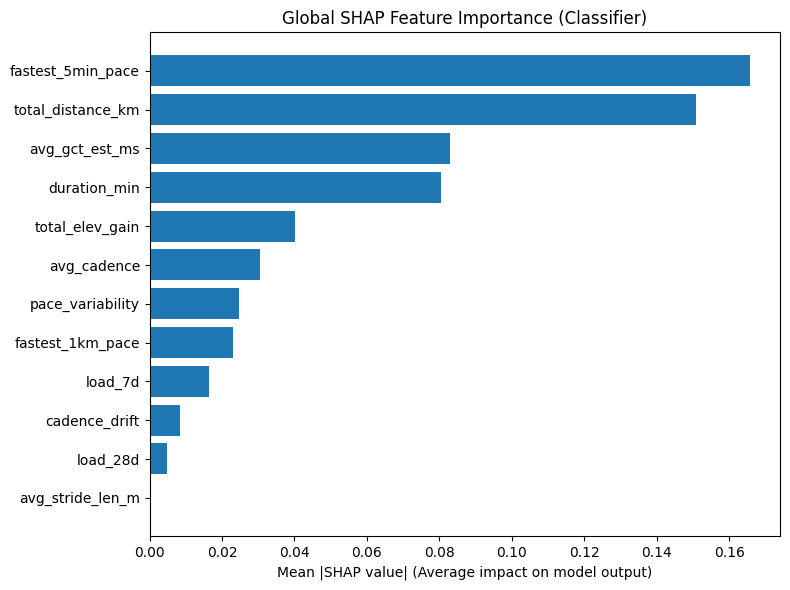

,mean_abs_shap
fastest_5min_pace,0.1657
total_distance_km,0.1509
avg_gct_est_ms,0.0829
duration_min,0.0806
total_elev_gain,0.0403
avg_cadence,0.0305
pace_variability,0.0247
fastest_1km_pace,0.0232
load_7d,0.0164
cadence_drift,0.0084


In [9]:
# ---------------------------------------------------
# 🌍 Global SHAP Summary — Fixed for Multi-Class Models
# ---------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute SHAP values for the classifier using aligned data
sv_all = explainer_clf.shap_values(X_clf_shap)

# --- Normalize shape (handles binary/multiclass) ---
if isinstance(sv_all, list):
    # sv_all is a list [array_for_class0, array_for_class1, ...]
    # → take mean absolute value across all classes
    shap_abs = np.mean([np.abs(vals) for vals in sv_all], axis=0)
else:
    arr = np.abs(sv_all)
    if arr.ndim == 3:  # (n_samples, n_features, n_classes)
        shap_abs = arr.mean(axis=2)  # average over classes
    else:
        shap_abs = arr  # (n_samples, n_features)

# --- Aggregate mean absolute SHAP per feature ---
mean_abs_shap = shap_abs.mean(axis=0)
shap_summary = pd.Series(mean_abs_shap, index=X_clf_shap.columns).sort_values(ascending=True)

# --- Plot stable global summary ---
plt.figure(figsize=(8, 6))
plt.barh(shap_summary.index, shap_summary.values)
plt.title("Global SHAP Feature Importance (Classifier)")
plt.xlabel("Mean |SHAP value| (Average impact on model output)")
plt.tight_layout()
plt.show()

# --- Display top drivers numerically ---
display(
    shap_summary.sort_values(ascending=False)
    .head(10)
    .to_frame("mean_abs_shap")
    .round(4)
)


In [10]:
#from pathlib import Path
#print("📍 Current working directory:", Path.cwd().resolve())


In [11]:
from pathlib import Path

# Define output path
output_path = Path("data/processed")
output_path.mkdir(parents=True, exist_ok=True)

# Save SHAP global summary
shap_summary.to_csv(output_path / "shap_summary.csv", index=False)
print("💾 Saved shap_summary.csv → data/processed/")



💾 Saved shap_summary.csv → data/processed/


In [12]:
# ---------------------------------------------------
# 🏷️ Ensure Cluster Labels Exist (Safe Merge)
# ---------------------------------------------------
# Notebook 5 may load runs_summary.csv (without clusters).
# This ensures we have cluster labels from Notebook 3 or
# predicts them with the trained classifier if missing.
# ---------------------------------------------------

from pathlib import Path

# Path to clustered dataset created in Notebook 3
cluster_path = data_dir / "runs_with_clusters.csv"

if "cluster" not in summary_df.columns:
    if cluster_path.exists():
        clusters_df = pd.read_csv(cluster_path, usecols=["run_id", "cluster"])
        summary_df = summary_df.merge(clusters_df, on="run_id", how="left")
        print(f"✅ Cluster labels merged from {cluster_path}")
    else:
        print("⚠️ Cluster file not found — predicting clusters using classifier.")
        summary_df["cluster"] = rf_clf.predict(summary_df[available_features])
else:
    print("✅ Cluster column already present in summary_df")

print("Cluster distribution:")
print(summary_df["cluster"].value_counts(dropna=False))


✅ Cluster labels merged from ..\data\processed\runs_with_clusters.csv
Cluster distribution:
cluster
NaN    416
0.0    206
1.0    133
2.0     36
3.0     35
Name: count, dtype: int64


🟡 Missing cluster labels: 416 runs


,run_id,date,total_distance_km,duration_min,avg_pace_min_km,min_pace_min_km,fastest_1km_pace,fastest_5min_pace,avg_cadence,total_elev_gain,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift,week,load_7d,load_28d,cluster
0,223706316,2014-09-29,13.41515,76.366667,NaN,NaN,NaN,NaN,NaN,1611.2,NaN,NaN,NaN,NaN,2014-09-29,13.41515,13.41515,NaN
1,224118153,2014-09-30,2.66860,9.350000,NaN,NaN,NaN,NaN,NaN,200.8,NaN,NaN,NaN,NaN,2014-09-29,16.08375,16.08375,NaN
2,224118406,2014-09-30,1.47677,7.100000,NaN,NaN,NaN,NaN,NaN,121.6,NaN,NaN,NaN,NaN,2014-09-29,17.56052,17.56052,NaN
3,224118046,2014-09-30,2.76147,9.350000,NaN,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,NaN,2014-09-29,20.32199,20.32199,NaN
4,224117880,2014-09-30,4.35972,19.000000,NaN,NaN,NaN,NaN,NaN,408.6,NaN,NaN,NaN,NaN,2014-09-29,24.68171,24.68171,NaN
5,224118290,2014-09-30,2.68965,9.116667,NaN,NaN,NaN,NaN,NaN,220.8,NaN,NaN,NaN,NaN,2014-09-29,27.37136,27.37136,NaN
6,227883054,2014-10-01,11.08239,49.850000,NaN,NaN,NaN,NaN,NaN,298.6,NaN,NaN,NaN,NaN,2014-09-29,38.45375,38.45375,NaN
7,227883160,2014-10-02,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2014-09-29,25.03860,38.45375,NaN
8,227883205,2014-10-03,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2014-09-29,22.37000,38.45375,NaN
9,227883234,2014-10-03,2.16066,11.916667,NaN,NaN,NaN,NaN,NaN,483.6,NaN,NaN,NaN,NaN,2014-09-29,23.05389,40.61441,NaN



📊 Summary statistics for unlabeled runs:


,count,mean,std,min,25%,50%,75%,max
total_distance_km,416.0,8.964053,6.006172,0.000000,4.094328,9.613100,12.131870,40.796130
avg_pace_min_km,320.0,10.456971,26.344401,1.818765,4.628330,5.096578,7.126067,389.990563
duration_min,416.0,58.783494,107.401096,0.000000,27.379167,50.416667,65.870833,1485.733333
avg_cadence,314.0,72.086722,23.897614,0.347059,79.626435,83.048797,84.467129,91.340909
total_elev_gain,416.0,152.572115,223.479265,0.000000,32.350000,85.000000,141.700000,1611.200000


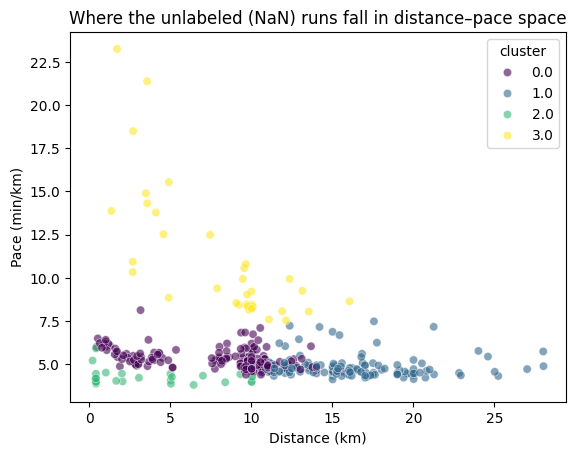

In [13]:
# ---------------------------------------------------
# 🔍 Inspect runs with missing cluster labels
# ---------------------------------------------------
missing_clusters = summary_df[summary_df["cluster"].isna()]

print(f"🟡 Missing cluster labels: {len(missing_clusters)} runs")
display(missing_clusters.head(10))

# --- Basic descriptive stats for the unlabeled runs ---
stats_missing = missing_clusters[
    ["total_distance_km", "avg_pace_min_km", "duration_min", "avg_cadence", "total_elev_gain"]
].describe().T

print("\n📊 Summary statistics for unlabeled runs:")
display(stats_missing)

# --- Optional: visualize where they fall relative to known clusters ---
sns.scatterplot(
    data=summary_df,
    x="total_distance_km",
    y="avg_pace_min_km",
    hue="cluster",
    palette="viridis",
    alpha=0.6
)
plt.title("Where the unlabeled (NaN) runs fall in distance–pace space")
plt.xlabel("Distance (km)")
plt.ylabel("Pace (min/km)")
plt.show()


In [ ]:
# ---------------------------------------------------
# 🧩 Predict missing cluster labels using trained model
# ---------------------------------------------------
to_predict = summary_df[summary_df["cluster"].isna()]
X_missing = to_predict[available_features].fillna(to_predict[available_features].mean())

predicted_labels = rf_clf.predict(X_missing)

# Add predictions back to the dataframe
summary_df.loc[summary_df["cluster"].isna(), "cluster"] = predicted_labels
print(f"✅ Filled {len(predicted_labels)} missing cluster labels with model predictions")
print(summary_df["cluster"].value_counts())



🔍 Easy Run — Local SHAP explanation
Predicted class: 0.0
Top contributors (abs SHAP):


,shap_value
total_distance_km,0.2484
duration_min,0.1310
fastest_1km_pace,-0.1050
avg_gct_est_ms,-0.0928
load_7d,-0.0359
pace_variability,0.0303
load_28d,0.0296
fastest_5min_pace,-0.0229
cadence_drift,-0.0120
avg_cadence,-0.0048


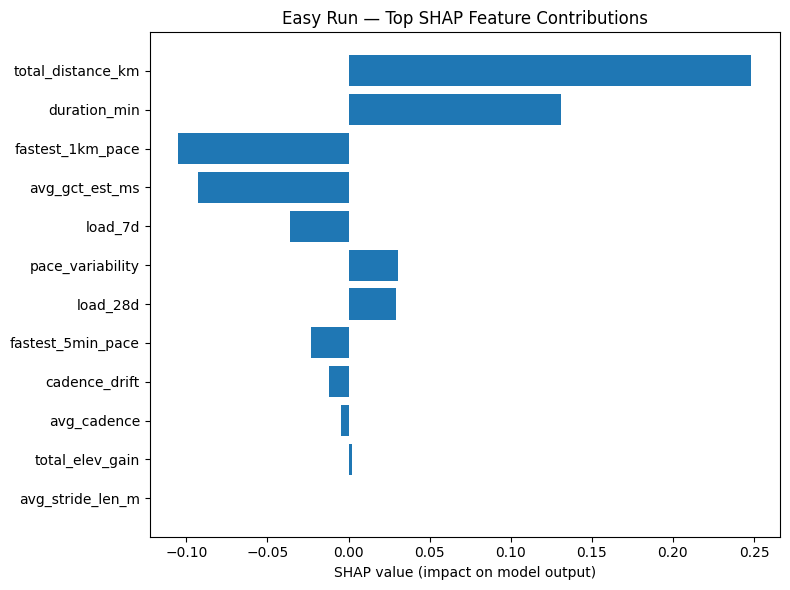


🔍 Endurance Run — Local SHAP explanation
Predicted class: 1.0
Top contributors (abs SHAP):


,shap_value
total_distance_km,0.1337
total_elev_gain,0.0786
avg_gct_est_ms,0.0762
duration_min,0.0714
fastest_1km_pace,0.0699
load_7d,-0.0576
pace_variability,-0.0562
fastest_5min_pace,0.0292
avg_cadence,0.0124
load_28d,0.0036


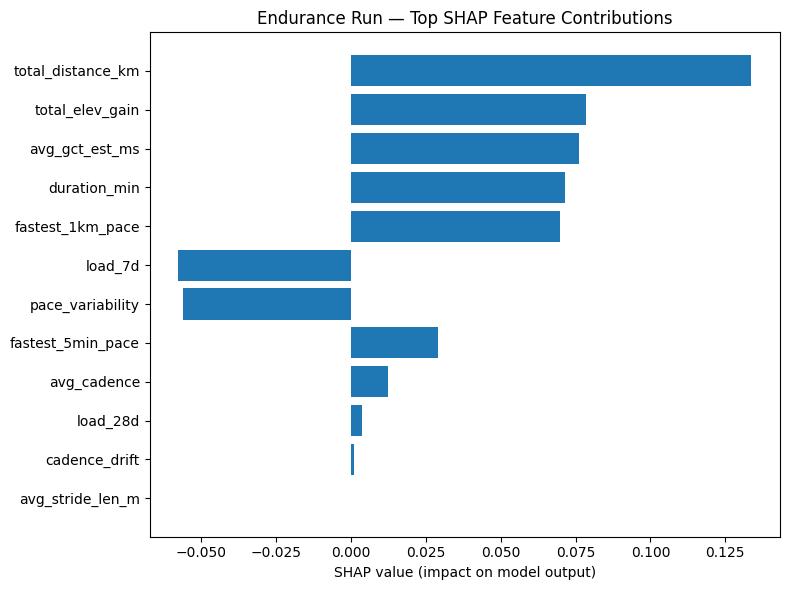


🔍 Interval Run — Local SHAP explanation
Predicted class: 0.0
Top contributors (abs SHAP):


,shap_value
total_distance_km,0.1503
total_elev_gain,0.1173
duration_min,0.1099
avg_gct_est_ms,-0.0844
load_7d,0.0342
fastest_1km_pace,0.0229
avg_cadence,0.0202
pace_variability,0.0195
fastest_5min_pace,0.0170
load_28d,0.0095


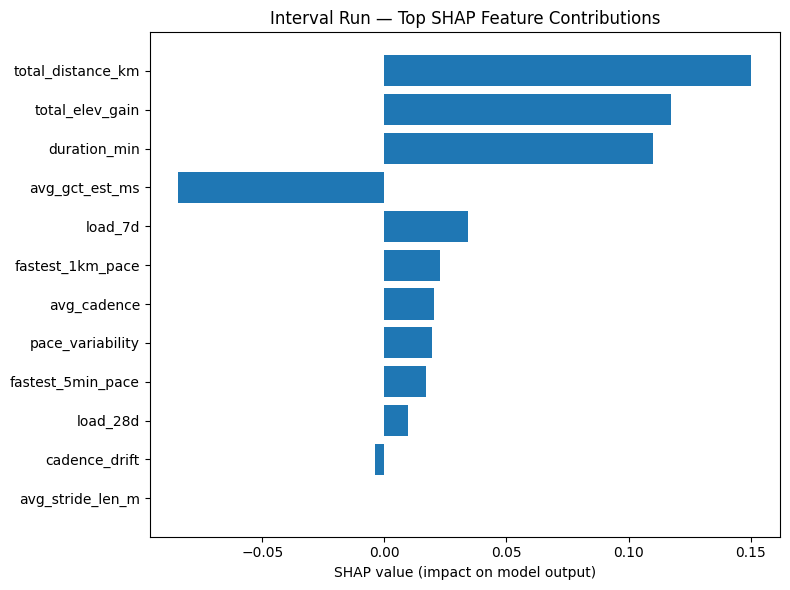

In [14]:
# ---------------------------------------------------
# 4️⃣ Case Studies — Local SHAP Explanations (robust, no SHAP plotting APIs)
# ---------------------------------------------------
# Computes SHAP values for the predicted class and shows a clear bar chart.
# This avoids force_plot/waterfall version traps and just works.
# ---------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _shap_vector_for_sample(explainer, model, X_row):
    """Return (1D shap vector for predicted class, predicted_label)."""
    # Predicted class index
    pred_label = model.predict(X_row)[0]
    classes = list(model.classes_)
    class_index = classes.index(pred_label)

    sv = explainer.shap_values(X_row)

    # Normalize various SHAP return shapes to 1D (n_features,)
    if isinstance(sv, list):  # classic multi-class: list of arrays [(1, n_features)] * n_classes
        vec = np.asarray(sv[class_index])[0]
    else:
        arr = np.asarray(sv)
        if arr.ndim == 3:         # (1, n_features, n_classes)
            vec = arr[0, :, class_index]
        elif arr.ndim == 2:
            # (1, n_features) or (n_features, n_classes) or (1, n_features*n_outputs) in some edge cases
            if arr.shape == (1, X_row.shape[1]):           # (1, n_features)
                vec = arr[0]
            elif arr.shape[0] == X_row.shape[1] and arr.shape[1] == len(classes):  # (n_features, n_classes)
                vec = arr[:, class_index]
            else:
                # fallback: first row and squeeze class if present
                tmp = arr[0]
                vec = tmp[:, class_index] if tmp.ndim == 2 and tmp.shape[1] == len(classes) else tmp
        else:                       # already (n_features,)
            vec = arr

    return vec, pred_label

# --- Pick example cases safely ---
cases = []
if "cluster" in summary_df.columns:
    if 0 in summary_df["cluster"].values:
        cases.append(("Easy Run", summary_df[summary_df["cluster"] == 0].sample(1, random_state=42)))
    if 1 in summary_df["cluster"].values:
        cases.append(("Endurance Run", summary_df[summary_df["cluster"] == 1].sample(1, random_state=42)))
    if 3 in summary_df["cluster"].values:
        cases.append(("Interval Run", summary_df[summary_df["cluster"] == 3].sample(1, random_state=42)))
else:
    print("⚠️ 'cluster' column missing; cannot pick per-cluster cases.")

if not cases:
    print("⚠️ No clusters found for case studies — check merged labels.")
else:
    for label, case in cases:
        print(f"\n🔍 {label} — Local SHAP explanation")
        case_X = case[available_features].iloc[[0]]

        shap_vec, pred_label = _shap_vector_for_sample(explainer_clf, rf_clf, case_X)
        contrib = pd.Series(shap_vec, index=case_X.columns).sort_values(key=lambda x: x.abs(), ascending=False)

        print(f"Predicted class: {pred_label}")
        print("Top contributors (abs SHAP):")
        display(contrib.head(10).to_frame("shap_value").round(4))

        # Bar chart (top 15 by absolute contribution)
        topk = contrib.head(15)[::-1]  # smallest at top so bars read top->bottom
        plt.figure(figsize=(8, 6))
        plt.barh(topk.index, topk.values)
        plt.title(f"{label} — Top SHAP Feature Contributions")
        plt.xlabel("SHAP value (impact on model output)")
        plt.tight_layout()
        plt.show()


In [ ]:
# ---------------------------------------------------
# 🏁 Wrap-Up — Notebook 5 Summary
# ---------------------------------------------------
# ✅ In this notebook we went beyond raw performance metrics to understand *why* the models behave as they do.
#
# 🔹 Key Results:
# - Extracted and visualized **feature importances** from Random Forest models.
# - Computed **SHAP values** to explain both classification and regression outputs.
# - Produced **global explanations** (which features drive predictions overall).
# - Generated **robust local explanations** (which factors shaped individual predictions)
#   using custom SHAP vector extraction — avoiding brittle SHAP plotting APIs.
#
# 🔹 Insights:
# - **Distance, cadence, elevation, and rolling load** consistently rank among the top drivers.
# - **Pace-related** and **load-based** metrics dominate the model’s decision logic.
# - Local SHAP bar charts reveal how small shifts in pace, duration, or training load
#   lead to different predicted run types — offering actionable feedback for training decisions.
#
# 🔹 Deliverables:
# - Clean plots for feature importances and SHAP summaries (exportable for reports or dashboards).
# - Unified feature handling and consistent interpretation across models.
# - Reusable case-study module for personalized model explanations.
#
# 🚀 Next Steps → Notebook 6
# ---------------------------------------------------
# Move from *interpretation* to *interaction*:
# - 🧭 Build an **interactive dashboard** (Streamlit or Dash).
# - 🔍 Enable **filtering, run comparisons, and on-demand predictions**.
# - 📈 Integrate **Garmin/Strava data inputs** for live visualization and feedback.
# - 🧩 Add **transparency tools** — e.g., dynamically show top SHAP contributors for any run.
# ---------------------------------------------------
